<a href="https://colab.research.google.com/github/olawale0254/ARFIMA/blob/master/pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pandas and numpy
import pandas as pd
from pandas import io as web##call web.data
import numpy as np

# dates
from datetime import datetime

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# formatting options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 78) 
pd.set_option('precision', 6)

In [2]:
!pip install zipline

In [3]:
import zipline as zp

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import zipline.utils.factory as zpf

In [13]:
df=pd.read_excel(r'/content/drive/My Drive/MSEFE/BTC-USD.xls', sheet_name="data_cryptocurrency", index_col='Date')

In [14]:
df.head()

            BTC-USD_close_price  ETH_USD_close_price  difference
Date                                                            
2015-08-07           279.584991             2.772120  276.812871
2015-08-08           260.997009             0.753325  260.243684
2015-08-09           265.083008             0.701897  264.381111
2015-08-10           264.470001             0.708448  263.761553
2015-08-11           270.385986             1.067860  269.318126

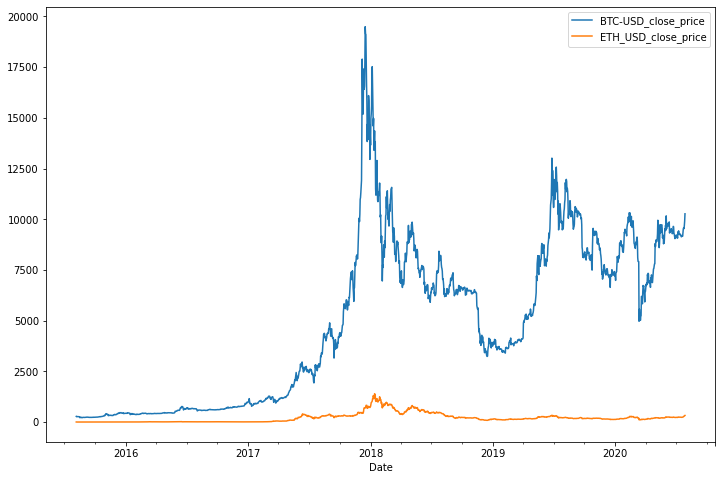

In [15]:
data=df[['BTC-USD_close_price', 'ETH_USD_close_price']]
data.plot(figsize=(12,8));

plt.savefig('5104OS_07_20.png', bbox_inches='tight', dpi=300)

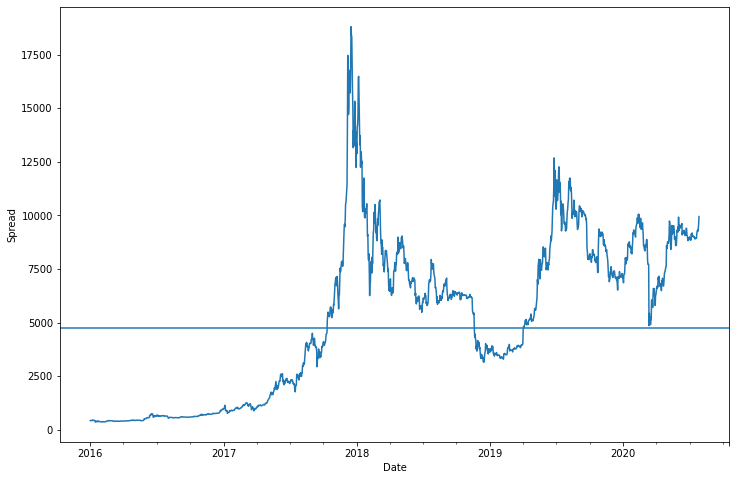

In [16]:
# calculate and plot the spread
data['Spread'] = df['difference']
data['2016':].Spread.plot(figsize=(12,8))
plt.ylabel('Spread')
plt.axhline(data.Spread.mean());
plt.savefig('5104OS_07_21.png', bbox_inches='tight', dpi=300)

In [22]:
# import statsmodels.api as sm
# #@zp.transforms.batch_transform
# def ols_transform(data):
#     """Compute the ordinary least squares of two series.
#     """
#     p0 = data['BTC-USD_close_price']
#     p1 = sm.add_constant(data['ETH_USD_close_price'], prepend=True)
#     slope, intercept = sm.OLS(p0, p1).fit().params

#     return slope, intercept

import statsmodels.api as sm
# @zp.transforms.batch_transform
def ols_transform(data):
    """Compute the ordinary least squares of two series.
    """
    p0 = data['BTC-USD_close_price']
    p1 = sm.add_constant(data['ETH_USD_close_price'], prepend=True)
    slope, intercept = sm.OLS(p0, p1).fit().params

    return slope, intercept

In [24]:
class Pairtrade(zp.TradingAlgorithm):
    """ Pairtrade algorithm for two stocks, using a window 
    of 100 days for calculation of the z-score and 
    normalization of the spread. We will execute on the spread 
    when the z-score is > 2.0 or < -2.0. If the absolute value 
    of the z-score is < 0.5, then we will empty our position 
    in the market to limit exposure.
    """
    def initialize(self, window_length=100):
        self.spreads=[]
        self.invested=False
        self.window_length=window_length
        self.ols_transform= \
            ols_transform(refresh_period=self.window_length,
                          window_length=self.window_length)

    def handle_data(self, data):
        # calculate the regression, will be None until 100 samples
        params=self.ols_transform.handle_data(data, 'BTC-USD_close_price', 'ETH-USD_close_price')
        if params:
            # get the intercept and slope
            intercept, slope=params

            # now get the z-score
            zscore=self.compute_zscore(data, slope, intercept)

            # record the z-score
            self.record(zscore=zscore)

            # execute based upon the z-score
            self.place_orders(data, zscore)

    def compute_zscore(self, data, slope, intercept):
        # calculate the spread
        spread=(data['BTC-USD_close_price']-(slope*data['ETH-USD_close_price']+ intercept))
        self.spreads.append(spread) # record for z-score calc
        self.record(spread = spread)
        
        # now calc the z-score
        spread_wind=self.spreads[-self.window_length:]
        zscore=(spread - np.mean(spread_wind))/np.std(spread_wind)
        return zscore

    def place_orders(self, data, zscore):
        if zscore>=2.0 and not self.invested:
            # buy the spread, buying PEP and selling KO
            self.order('BTC-USD_close_price', int(100/data['BTC-USD_close_price']))
            self.order('ETH-USD_close_price', -int(100/data['ETH-USD_close_price']))
            self.invested=True
            self.record(action="PK")
        elif zscore<=-2.0 and not self.invested:
            # buy the spread, buying KO and selling PEP
            self.order('BTC-USD_close_price', -int(100 / data['BTC-USD_close_price']))
            self.order('ETH-USD_close_price', int(100 / data['ETH-USD_close_price']))
            self.invested = True
            self.record(action='KP')
        elif abs(zscore)<.5 and self.invested:
            # minimize exposure
            ko_amount=self.portfolio.positions['ETH-USD_close_price'].amount
            self.order('ETH-USD_close_price', -1*ko_amount)
            pep_amount=self.portfolio.positions['BTC-USD_close_price'].amount
            self.order('BTC-USD_close_price', -1*pep_amount)
            self.invested=False
            self.record(action='DE')
        else:
            # take no action
            self.record(action='noop')

In [27]:
perf = Pairtrade().run(data['2018':])

TypeError: ignored